# Verification of LiH pulses from Strict Partial Compilation

In [1]:
import sys
sys.path.append('../..')
import config
from fqc import uccsd, util, core
from fqc.models import Pulse

import numpy as np
from datetime import datetime

data_path = config.DATA_PATH
file_name = datetime.today().strftime('%h%d')

In [2]:
from quantum_optimal_control.helper_functions.grape_functions import transmon_gate
from quantum_optimal_control.main_grape.grape import Grape
from quantum_optimal_control.core import hamiltonian

In [3]:
d = 2  # this is the number of energy levels to consider (i.e. d-level qudits)
max_iterations = 6000
decay =  max_iterations / 2
convergence = {'rate':0.01, 'max_iterations': max_iterations,
               'conv_target':1e-3, 'learning_rate_decay':decay, 'min_grad': 1e-12, 'update_step': 20}
reg_coeffs = {}

In [4]:
N = 4
connected_qubit_pairs = util.get_nearest_neighbor_coupling_list(2, 2, directed=False)
H0 = np.zeros((d ** N, d ** N))
Hops, Hnames = hamiltonian.get_Hops_and_Hnames(N, d, connected_qubit_pairs)
states_concerned_list = hamiltonian.get_full_states_concerned_list(N, d)
maxA = hamiltonian.get_maxA(N, d, connected_qubit_pairs)

In [5]:
circuit = uccsd.get_uccsd_circuit('LiH')

In [6]:
U_all = util.get_unitary(circuit)
print(U_all.shape)

(16, 16)


In [7]:
slices = uccsd.get_uccsd_slices(circuit, granularity=1)
print(len(slices))
print(len([slice for slice in slices if not slice.parameterized]))

81
41


### Find all pulse files with minimum time

In [9]:
import os
times = []
fixed_files = ['' for _ in range(len([slice for slice in slices if not slice.parameterized]))]
for filename in os.listdir('LiH/'):
    if filename.endswith('.out'):
        lines = open('LiH/%s' % filename).readlines()
        if len(lines) > 5 and lines[0].startswith('Running Block:  '):
            index = int(lines[0][len('Running Block:  '):])

        if len(lines) > 5 and lines[-1].startswith('^^^SHORTEST TIME was '):
            result = lines[-1]
            time = float(result[len('^^^SHORTEST TIME was '):])
            if time > 50:
                print(time, filename)
            else:
                times.append(time)
            for (i, line) in enumerate(lines):
                if line.startswith("trying total_time: " + str(time)) and i < len(lines):
                    pulse_file = lines[i+1][len('data saved at: '):-1]
                    fixed_files[index] = pulse_file
            
            
print(len(times))
print(len(fixed_files))

41
41


In [10]:
print(fixed_files[20])

/project/ftchong/qoc/pranav/00006_28_fixed_slice_20.h5


Error: 4.062569e-02


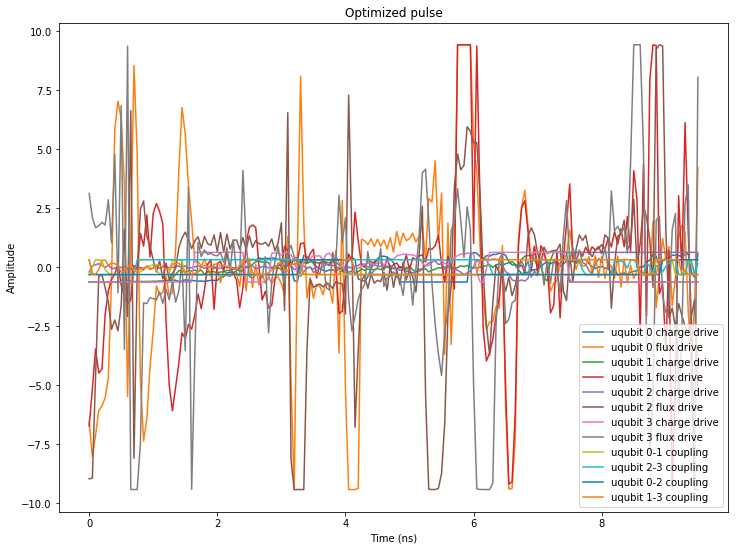

In [11]:
util.plot_pulse_from_file(fixed_files[20], save_plot=False)

In [15]:
all_res = []
errors = []
j = 0
for (i, slice) in enumerate(slices):
    if slice.parameterized:
        U = slice.unitary()
        total_time = util.circuitutil.get_max_pulse_time(slice.circuit)
        steps = int(total_time * 20)
        res = Grape(H0, Hops, Hnames, U, total_time, steps, states_concerned_list, convergence,
                         reg_coeffs=reg_coeffs,
                         use_gpu=False, sparse_H=False, method='Adam', maxA=maxA,
                         show_plots=False, file_name=file_name+"_LiH"+str(i), data_path=data_path)
        all_res.append(res)
        errors.append(res.l)
    else:
        res = util.evol_pulse_from_file(fixed_files[j], save=True, out_file=file_name+"_LiH"+str(i), out_path=data_path)
        all_res.append(res)
        errors.append(res.l)
        j = j + 1
        

data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH0.h5
Using 8 Taylor terms and 1 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :9.99e-04; Runtime: 0.3s; Iterations = 0, grads =   1.508e-04, unitary_metric = 1.00000
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH0.h5
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH1.h5
Using 6 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :7.04e-01; Runtime: 0.1s; Iterations = 0, gra

Graph built!
Initialized
Error = :9.83e-01; Runtime: 0.1s; Iterations = 0, grads =   1.085e-02, unitary_metric = 1.00000
Error = :7.86e-01; Runtime: 0.3s; Iterations = 20, grads =   1.125e-01, unitary_metric = 1.00000
Error = :4.42e-01; Runtime: 0.5s; Iterations = 40, grads =   1.501e-01, unitary_metric = 1.00000
Error = :1.64e-01; Runtime: 0.6s; Iterations = 60, grads =   7.135e-02, unitary_metric = 1.00000
Error = :4.38e-02; Runtime: 0.8s; Iterations = 80, grads =   1.863e-02, unitary_metric = 1.00000
Error = :9.78e-03; Runtime: 1.0s; Iterations = 100, grads =   3.823e-03, unitary_metric = 1.00000
Error = :1.95e-03; Runtime: 1.2s; Iterations = 120, grads =   7.158e-04, unitary_metric = 1.00000
Error = :9.92e-04; Runtime: 1.3s; Iterations = 128, grads =   3.582e-04, unitary_metric = 1.00000
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH11.h5
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH12.h5
Using 7 Taylor terms and 2 Scaling & Squaring terms
Building grap

data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH22.h5
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH23.h5
Using 6 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :2.39e-01; Runtime: 0.1s; Iterations = 0, grads =   1.367e-01, unitary_metric = 1.00000
Error = :7.99e-03; Runtime: 0.3s; Iterations = 20, grads =   6.226e-03, unitary_metric = 1.00000
Error = :2.39e-03; Runtime: 0.5s; Iterations = 40, grads =   1.841e-03, unitary_metric = 1.00000
Error = :9.88e-04; Runtime: 0.6s; Iterations = 49, grads =   7.565e-04, unitary_metric = 1.00000
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH23.h5
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH24.h5
Using 7 Taylor terms 

data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH34.h5
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH35.h5
Using 6 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :1.33e-01; Runtime: 0.1s; Iterations = 0, grads =   9.684e-02, unitary_metric = 1.00000
Error = :1.66e-03; Runtime: 0.3s; Iterations = 20, grads =   1.255e-03, unitary_metric = 1.00000
Error = :9.40e-04; Runtime: 0.3s; Iterations = 21, grads =   6.629e-04, unitary_metric = 1.00000
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH35.h5
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH36.h5
Using 7 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initiali

data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH46.h5
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH47.h5
Using 6 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :2.00e-01; Runtime: 0.1s; Iterations = 0, grads =   1.141e-01, unitary_metric = 1.00000
Error = :4.96e-03; Runtime: 0.3s; Iterations = 20, grads =   3.526e-03, unitary_metric = 1.00000
Error = :2.27e-03; Runtime: 0.5s; Iterations = 40, grads =   1.676e-03, unitary_metric = 1.00000
Error = :9.65e-04; Runtime: 0.5s; Iterations = 47, grads =   6.901e-04, unitary_metric = 1.00000
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH47.h5
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH48.h5
Using 7 Taylor terms 

Graph built!
Initialized
Error = :9.98e-04; Runtime: 0.4s; Iterations = 0, grads =   8.046e-05, unitary_metric = 0.99998
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH58.h5
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH59.h5
Using 6 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :4.39e-01; Runtime: 0.1s; Iterations = 0, grads =   1.719e-01, unitary_metric = 1.00000
Error = :9.36e-02; Runtime: 0.3s; Iterations = 20, grads =   6.370e-02, unitary_metric = 1.00000
Error = :3.95e-03; Runtime: 0.5s; Iterations = 40, grads =   2.749e-03, unitary_metric = 1.00000
Error = :8.02e-04; Runtime: 0.5s; Iterations = 46, grads =   5.436e-04, unitary_metric = 1.00000
data saved at: /project/ftchong/

Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :1.12e-01; Runtime: 0.1s; Iterations = 0, grads =   7.548e-02, unitary_metric = 1.00000
Error = :3.98e-03; Runtime: 0.3s; Iterations = 20, grads =   3.157e-03, unitary_metric = 1.00000
Error = :8.24e-04; Runtime: 0.4s; Iterations = 35, grads =   6.170e-04, unitary_metric = 1.00000
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH71.h5
data saved at: /project/ftchong/qoc/yongshan/00000_Mar30_LiH72.h5
Using 7 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
In

In [16]:
qubits = [0,1,2,3]
all_files = [data_path+"/00000_"+file_name+"_LiH%d.h5" % i for i in range(len(slices))]
all_pulses = [Pulse(N, d, qubits, fname=f) for f in all_files]

In [ ]:
res = core.concat_and_evol(N, d, all_pulses, U_all, file_name=file_name, data_path=data_path)

data saved at: /project/ftchong/qoc/yongshan/00001_Mar30.h5
Using 8 Taylor terms and 2 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.


In [47]:
print("Errors for all %d slices:" % len(errors))
print(errors)
print('\n---------------------\n')
print("Final concatenated error:")
print(res.l)

Errors for all 9 slices:
[0.0009949207, 0.0008921623, 0.0009997487, 0.00095051527, 0.0009964705, 0.0008729696, 0.0009993911, 0.0008211136, 0.0009993911]

---------------------

Final concatenated error:
0.008874416
